# Task definition
Implement LSTM Sentiment Tagger for imdb reviews dataset.

1. (5pt) Fill missing code below
    * 1pt implement vectorization
    * 2pt implement \_\_init\_\_ and forward methods of models
    * 2pt implement collate function
2. (4pt) Implement training loop, choose proper loss function, use clear ml for max points.
    * 2pts is a baseline for well written, working code
    * 2pts if clear ml used properly
3. (3pt) Train the models (find proper hyperparams). Make sure you are not overfitting or underfitting. Visualize training of your best model (plot training, and test loss/accuracy in time). Your model should reach at least 87% accuracy. For max points it should exceed 89%. 
    * 1pt for accuracy above 89%
    * 1pt for accuracy above 87%
    * 1pt for visualizations

Remarks:
* Use embeddings of size 50
* Use 0.5 threshold when computing accuracy.
* Use supplied dataset for training and evaluation.
* You do not have to use validation set.
* You should monitor overfitting during training.
* For max points use clear ml to store and manage logs from your experiments. 
* We encourage to use pytorch lightning library (Addtional point for using it - however the sum must not exceed 12)

[Clear ML documentation](https://clear.ml/docs/latest/docs/)

[Clear ML notebook exercise from bootcamp](https://colab.research.google.com/drive/1wtLb4gg8beLS7smcyJlOZppn6_rQvSxL?usp=sharing)

In [15]:
!pip install clearml
!pip install pytorch-lightning

import os
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torchtext
from clearml import Task

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import pytorch_lightning as pl

In [16]:
web_server = 'https://app.community.clear.ml'
api_server = 'https://api.community.clear.ml'
files_server = 'https://files.community.clear.ml'
access_key = ' '#@param {type:"string"}
secret_key = ''#@param {type:"string"}

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

In [17]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1hK-3iiRPlbePb99Fe-34LJNZ5yB-nduq
!tar -xvzf imdb_dataset.gz
data = pd.read_csv("imdb_dataset.csv")

Downloading...
From: https://drive.google.com/uc?id=1hK-3iiRPlbePb99Fe-34LJNZ5yB-nduq
To: /content/imdb_dataset.gz
100% 77.0M/77.0M [00:00<00:00, 245MB/s]
imdb_dataset.csv


No handles with labels found to put in legend.


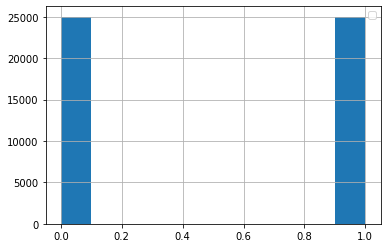

In [18]:
data['sentiment'].hist()

In [19]:
data

,Unnamed: 0,text,split,id,stars,sentiment,tokenized
0,0,"Gary Cooper, (Michael Brandon) played the role...",test,6182,8,1.0,"gary cooper , ( michael brandon ) played the r..."
1,1,"This film is a tapestry, a series of portraits...",test,7654,10,1.0,"this film is a tapestry , a series of portrait..."
2,2,i see there are great reviews of this film alr...,test,10435,7,1.0,i see there are great reviews of this film alr...
3,3,This film says everything there is to say abou...,test,10476,10,1.0,this film says everything there is to say abou...
4,4,Apparently this Australian film based on Nevil...,test,9769,9,1.0,apparently this australian film based on nevil...
...,...,...,...,...,...,...,...
99995,99995,Wow! I am still in absolute shock from this fi...,unsup,13698,0,NaN,wow ! i am still in absolute shock from this f...
99996,99996,As someone who always likes to solve the New Y...,unsup,6887,0,NaN,as someone who always likes to solve the new y...
99997,99997,What can i say positive about this movie? Abso...,unsup,13748,0,NaN,what can i say positive about this movie ? abs...
99998,99998,I am really amazed how bad acting can really b...,unsup,48085,0,NaN,i am really amazed how bad acting can really b...


In [20]:
PADDING_VALUE = 0

class NaiveVectorizer:
    def __init__(self, tokenized_data, **kwargs):
        """Converts data from string to vector of ints that represent words. 
        Prepare lookup dict (self.wv) that maps token to int. Reserve index 0 for padding.
        """
        tokenized_data = [seq.split() for seq in tokenized_data]
        ### Your code goes here ###
        self.wv = dict()
        iter = PADDING_VALUE + 1
        for sequence in tokenized_data:
          for word in sequence:
            if word not in self.wv:
              self.wv[word] = iter
              iter += 1
        ##################################

    def vectorize(self, tokenized_seq):
        """Converts sequence of tokens into sequence of indices.
        If the token does not appear in the vocabulary(self.wv) it is ommited
        Returns torch tensor of shape (seq_len,) and type long."""
        ### Your code goes here ###
        tokens = []
        for word in tokenized_seq:
          if word in self.wv:
            tokens.append(self.wv[word])
            
        return torch.LongTensor(tokens)
        ##################################

In [21]:
class ImdbDataset(Dataset):
    SPLIT_TYPES = ["train", "test", "unsup"]

    def __init__(self, data, preprocess_fn, split="train"):
        super(ImdbDataset, self).__init__()
        if split not in self.SPLIT_TYPES:
            raise AttributeError(f"No such split type: {split}")

        self.split = split
        self.label = [i for i, c in enumerate(data.columns) if c == "sentiment"][0]
        self.data_col = [i for i, c in enumerate(data.columns) if c == "tokenized"][0]
        self.data = data[data["split"] == self.split]
        self.preprocess_fn = preprocess_fn

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.preprocess_fn(self.data.iloc[idx, self.data_col].split())
        label = self.data.iloc[idx, self.label]
        return (seq, label)

In [22]:
naive_vectorizer = NaiveVectorizer(data.loc[data["split"] == "train", "tokenized"])

def get_datasets():
    train_dataset = ImdbDataset(data, naive_vectorizer.vectorize)
    test_dataset = ImdbDataset(data, naive_vectorizer.vectorize, split="test")
        
    return train_dataset, test_dataset

def custom_collate_fn(pairs):
    """This function is supposed to be used by dataloader to prepare batches
    Input: list of tuples (sequence, label)
    Output: sequences_padded_to_the_same_lenths, original_lenghts_of_sequences, lables.
    torch.nn.utils.rnn.pad_sequence might be usefull here
    """
    ### Your code goes here ###
    seqcs, lengths, labels = [], [], []
    for pair in pairs:
      labels.append(pair[1])
      lengths.append(len(pair[0]))
      seqcs.append(pair[0])

    seqcs = pad_sequence(seqcs, padding_value=PADDING_VALUE)
    lengths = torch.LongTensor(lengths)
    labels = torch.Tensor(labels)
    #################################
    return seqcs, lengths, labels

In [23]:
import torchmetrics

In [24]:
"""Implement LSTMSentimentTagger. 
The model should use a LSTM module.
Use torch.nn.utils.rnn.pack_padded_sequence to optimize processing of sequences.
When computing vocab_size of embedding layer remeber that padding_symbol counts to the vocab.
Use sigmoid activation function.
"""

class LitLSTMSentimentTagger(pl.LightningModule):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, classes, batch_size, dropout_prob, num_layers, lr):
        super(LitLSTMSentimentTagger, self).__init__()

        ### Your code goes here ###
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lr = lr

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers =num_layers, dropout=dropout_prob)
        self.linear = nn.Linear(hidden_dim, classes)
        self.drop = nn.Dropout(dropout_prob)

        self.loss = nn.BCELoss()
        self.train_accuracy = torchmetrics.Accuracy()
        self.valid_accuracy = torchmetrics.Accuracy()
        #################################

    def forward(self, sentence, lengths):
        ### Your code goes here ###
        batch_size = sentence.shape[1]

        embeddings = self.embedding(sentence)
        embeddings = self.drop(embeddings)

        packed_embeddings = pack_padded_sequence(embeddings, lengths.cpu(), enforce_sorted=False)
        lstm_out, _ = self.lstm(packed_embeddings)
        output, hidden = pad_packed_sequence(lstm_out)

        out = output[lengths - 1, range(batch_size) , :]

        x = self.linear(out)
        x = x.squeeze()
        scores = torch.sigmoid(x)
        #################################
        return scores
    

    def setup(self, stage=None):
        self.training_data, self.val_data = get_datasets()


    def train_dataloader(self):
        return DataLoader(self.training_data, batch_size=self.batch_size, 
                          shuffle=True, collate_fn=custom_collate_fn)


    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, 
                          shuffle=False, collate_fn=custom_collate_fn)


    def training_step(self, batch, batch_idx):

        seqcs, lengths, labels = batch

        pred = self(seqcs, lengths)

        loss = self.loss(pred, labels)
        acc = self.train_accuracy(torch.round(pred), labels.to(torch.int32))

        self.log('loss', {'train': loss}, on_step=False, on_epoch=True, batch_size=labels.size()[0])
        self.log('acc', {'train': acc}, on_step=False, on_epoch=True, batch_size=labels.size()[0])

        return {'loss': loss, 'accuracy': acc}


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


    def validation_step(self, batch, batch_idx):

        seqcs, lengths, labels = batch

        pred = self(seqcs, lengths)

        loss = self.loss(pred, labels)
        acc = self.valid_accuracy(torch.round(pred), labels.to(torch.int32))

        self.log('loss', {'valid': loss}, on_step=False, on_epoch=True, batch_size=labels.size()[0])
        self.log('acc', {'valid': acc},  on_step=False, on_epoch=True, batch_size=labels.size()[0])

        return {'val_loss': loss, 'val_accuracy': acc}   

# Trainig loop and visualizations


In [25]:
task = Task.init(project_name='GSN_homework_3', task_name='lightning')
task.mark_started()
logger = task.get_logger()

ClearML Task: created new task id=4495e2aa8a564704ad41b3b97bbb7166
ClearML results page: https://app.community.clear.ml/projects/60e3bb88f59447af81f9baef2d3d8c6b/experiments/4495e2aa8a564704ad41b3b97bbb7166/output/log
2022-01-14 21:15:49,752 - clearml.Task - INFO - No repository found, storing script code instead


In [26]:
config = {
    'n_epochs': 25,
    'lr': 1e-3,
    'batch_size': 128, 
    'optimizer': 'Adam',
    'hidden_dim': 128, 
    'embedding_dim': 50,
    'dropout': 0.5, 
    'num_layers': 2
}
task.connect(config)

{'batch_size': 128,
 'dropout': 0.5,
 'embedding_dim': 50,
 'hidden_dim': 128,
 'lr': 0.001,
 'n_epochs': 25,
 'num_layers': 2,
 'optimizer': 'Adam'}

In [27]:
trainer = pl.Trainer(max_epochs=config['n_epochs'], gpus=1)
model = LitLSTMSentimentTagger(embedding_dim=config['embedding_dim'], hidden_dim=config['hidden_dim'], vocab_size=len(naive_vectorizer.wv)+1, classes=1, batch_size=config['batch_size'], dropout_prob=config['dropout'], num_layers=config['num_layers'], lr=config['lr'])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type      | Params
---------------------------------------------
0 | embedding      | Embedding | 4.4 M 
1 | lstm           | LSTM      | 224 K 
2 | linear         | Linear    | 129   
3 | drop           | Dropout   | 0     
4 | loss           | BCELoss   | 0     
5 | train_accuracy | Accuracy  | 0     
6 | valid_accuracy | Accuracy  | 0     
---------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.303    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [28]:
task.mark_completed()
task.close()

In [30]:
task_list = Task.get_tasks(
    project_name='GSN_homework_3',
    tags= ['best']
)

In [68]:
data = dict()
for task in task_list:
    metrics = task.get_reported_scalars()
    data['train_acc'] = metrics['acc']['train']['y']
    data['valid_acc'] = metrics['acc']['valid']['y']
    data['train_loss'] = metrics['loss']['train']['y']
    data['valid_loss'] = metrics['loss']['valid']['y']

In [51]:
import plotly.express as px
import plotly.graph_objects as go

In [69]:
df = pd.DataFrame(data)

In [62]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['train_acc'],
    hovertext=df['train_acc'],
    hoverinfo="text",
    name='train',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))


fig.add_trace(go.Scatter(
    x=df.index,
    y=df['valid_acc'],
    hovertext=df['valid_acc'],
    name='validation',
    hoverinfo="text",
    marker=dict(
        color="green"
    ),
    showlegend=True
))
fig.update_layout(hovermode='x', title = 'Accuracy plot for the best model')

fig.show()

In [70]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=df.index,
    y=df['train_loss'],
    hovertext=df['train_loss'],
    hoverinfo="text",
    name='train',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))


fig2.add_trace(go.Scatter(
    x=df.index,
    y=df['valid_loss'],
    hovertext=df['valid_loss'],
    name='validation',
    hoverinfo="text",
    marker=dict(
        color="green"
    ),
    showlegend=True
))
fig2.update_layout(hovermode='x', title = 'Loss plot for the best model')

fig2.show()